# Exploring the relationship between commercial flights delays <br/> and airline stock prices

Flight delays suck, but more and more (at least in my personal experience) they seem to be the norm in modern airline travel. As much as we may demonize the major airlines ([they often make it easy](http://fortune.com/2016/03/01/airlines-basic-economy/), after all) delays certainly aren't in their interest.

As passengers, we often feel powerles to actually *do* anything about the inconveniences of air travel, but it's nice to imagine that the invisible hand of the marketplace will end up penalizing those airlines that have lots of delays, and rewarding those that do not. A pipe dream? Seems likely. Something we can look for quantitatively? Yes!

So how can we go about it?

The gist will be to look at the relationship between flights delays (and some related measures, like flight cancellations) and the stocks prices of major airlines over time. We'll start with some descriptive and correlational analyses, but these are of limited value for answering the questioin above. The next step will be to try something more robust for establishing a link between delays and stock prices, namely Granger causality analysis.

For this small-scale analysis, we'll only look at one year of data (2015) from the top US airlines to keep the data size manageable (all the code here runs just fine on Macbook Pro with 16GB of RAM). Of course a more robust analysis would look at a longer time scale, but this is just for fun, after all. 

According to [Wikipedia](https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America), the top four US carriers in 2015 were American, Delta, Southwest, and United. Each of those airlines carried between 140 and 200 million passengers in 2015. JetBlue was a distant fifth place, with only about 35 million passengers, so we'll stick with the top four. 

The bureau of transportation statistics requires airlines to report a variety of interesting data on flights delays, which we can freely download [here](http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236), and [Yahoo! Finance](https://finance.yahoo.com/) makes it easy to download historical stock price data. 

That's the plan, so let's get started. Fair warning, in the end our results aren't conclusive, but this is still a fun lttle analysis.

### Preliminaries

Tools like Spark, Graphlab Create, etc. are great when working with really big datasets, but for something comparatively small like this (~6M rows) I prefer to used Pandas, especially for exploratory analysis. So let's start by importing that, plus a few other useful modules.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os,glob
import numpy as np
# we need this so our visuals show up in the notebook
%matplotlib inline 

### Getting the flight data

Unfortunately, the BTS site doesn't make this as simple as it could, forcing us to manually download each month of data. In principle we could use [mechanize](https://pypi.python.org/pypi/mechanize/) or a similar tool to programatically download the data we care about, but for our purposes here let's keep it simple and manually download the 12 months of data we care about. Once we have the 12 `.csv` files (stored in the folder `data` in our working directory), we can load them into one big Pandas dataframe.

In [2]:
files = glob.glob(os.path.join('data', "2015*.csv"))
flight_data = pd.concat((pd.read_csv(f,parse_dates=['FL_DATE'],index_col='FL_DATE') for f in files))

Here are all the columns I selected when loading the data. Note that the `Unnamed:33` column is an artifact of buggy output from the BTS download tool, which puts an extraneous column at the end of each row. Many of these are self-explanatory, and I'll describe the ones that aren't as they come up.

In [3]:
print ', '.join(flight_data.columns)

UNIQUE_CARRIER, AIRLINE_ID, CARRIER, TAIL_NUM, FL_NUM, ORIGIN_AIRPORT_ID, ORIGIN_AIRPORT_SEQ_ID, ORIGIN_CITY_MARKET_ID, ORIGIN, DEST_AIRPORT_ID, DEST_AIRPORT_SEQ_ID, DEST_CITY_MARKET_ID, DEST, CRS_DEP_TIME, DEP_TIME, DEP_DELAY, DEP_DELAY_NEW, CRS_ARR_TIME, ARR_TIME, ARR_DELAY, ARR_DELAY_NEW, CANCELLED, DIVERTED, CRS_ELAPSED_TIME, ACTUAL_ELAPSED_TIME, FLIGHTS, DISTANCE, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY, Unnamed: 33


To make everything a bit more interpretable, let's match the `UNIQUE_CARRIER` codes used in the BTS database to the airlines' actual names, which we can get from the lookup table linked on the same page where we got the raw data. 

In [4]:
carrier_data = pd.read_csv("data/L_UNIQUE_CARRIERS.csv",index_col='Code')
carrier_data.columns = ['airline_name']
carrier_data.head()

,airline_name
Code,
02Q,Titan Airways
04Q,Tradewind Aviation
05Q,"Comlux Aviation, AG"
06Q,Master Top Linhas Aereas Ltd.
07Q,Flair Airlines Ltd.


In [5]:
flight_data = flight_data.join(carrier_data,on="UNIQUE_CARRIER")

Now let's filter the data down to just the four airlines we care about:

In [6]:
# Grab the unique airline names so we format them correctly in the next step
flight_data['airline_name'].unique()

array(['ExpressJet Airlines Inc.', 'Frontier Airlines Inc.',
       'Hawaiian Airlines Inc.', 'Envoy Air', 'Spirit Air Lines',
       'SkyWest Airlines Inc.', 'American Airlines Inc.',
       'Alaska Airlines Inc.', 'JetBlue Airways', 'Delta Air Lines Inc.',
       'United Air Lines Inc.', 'US Airways Inc.', 'Virgin America',
       'Southwest Airlines Co.'], dtype=object)

In [7]:
top_carriers = ['American Airlines Inc.','Delta Air Lines Inc.','Southwest Airlines Co.','United Air Lines Inc.']
starting_total_flights = len(flight_data)
flight_data = flight_data[flight_data['airline_name'].isin(top_carriers)]
print "Total flights after filtering: {:,d} => {:,d}".format(starting_total_flights,len(flight_data))

Total flights after filtering: 5,819,079 => 3,379,443


Now we can get some basic, per-carrier summary views on the data:

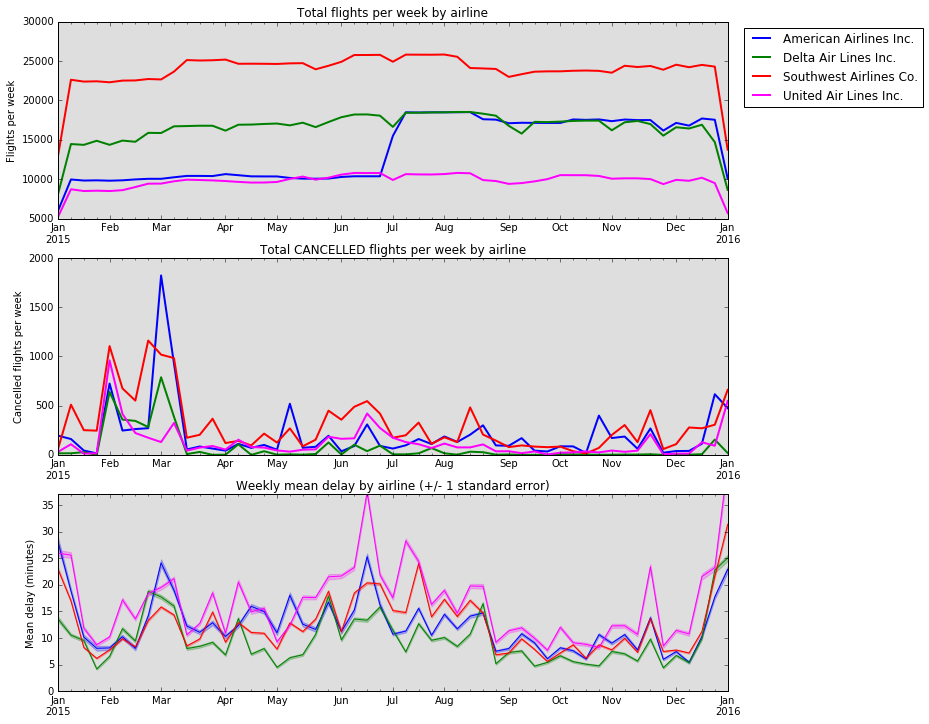

In [8]:
# to ensure consistent color usage throughout 
colors = ('blue','green','red','magenta')

fig,axes = plt.subplots(3,1,figsize=(12,12))
count_data = flight_data.groupby('airline_name')['UNIQUE_CARRIER'].resample('W',how='count').unstack(level=0)
count_data.plot(ax=axes[0],legend=None,lw=2,color=colors)
axes[0].legend(bbox_to_anchor=(1.3,1.0))
axes[0].set_ylabel("Flights per week")
axes[0].set_xlabel('')
axes[0].set_title("Total flights per week by airline",fontsize='large')
axes[0].legend(bbox_to_anchor=(1.3,1.0))

cancellation_data = flight_data.groupby('airline_name')['CANCELLED'].resample('W',how='sum').unstack(level=0)
cancellation_data.plot(ax=axes[1],legend=None,lw=2,color=colors)
axes[1].set_ylabel("Cancelled flights per week")
axes[1].set_xlabel('')
axes[1].set_title("Total CANCELLED flights per week by airline",fontsize='large')

mean_data = flight_data.groupby('airline_name')['DEP_DELAY_NEW'].resample('W',how='mean').unstack(level=0) 
se_data = flight_data.groupby('airline_name')['DEP_DELAY_NEW'].resample('W',how='std').unstack(level=0) / np.sqrt(count_data)
mean_data.plot(ax=axes[2],legend=None,color=colors)
for col,c in zip(mean_data.columns,colors):
    axes[2].fill_between(mean_data.index,mean_data[col]-se_data[col],mean_data[col]+se_data[col],alpha=0.25,color=c)
axes[2].set_ylim(0,37)
axes[2].set_xlabel('')
axes[2].set_ylabel('Mean delay (minutes)')
axes[2].set_title("Weekly mean delay by airline (+/- 1 standard error)")

for ax in axes:
    ax.patch.set_facecolor('#DEDEDE')

It's worth making a few comments here. Probably the most shocking thing to notice is the huge jump in flights for American around July. After some investigation, it turns out that this is when the [merger](https://en.wikipedia.org/wiki/American_Airlines_Group) between US Airways and American Airlines, initiated in 2013, began to take effect. We'll have to keep this in mind as we proceed through the rest of our analysis.

There are some other observations of interest, such as the large number of cancellations in January-March across all airlines (perhaps due to winter weather, though American seems to have had a particularly problematic March) and that United seems to be the biggest culprit in terms of departure delays. Also of note is that Southwest, despite not having the greatest number of passengers (at least according to [this page]([Wikipedia](https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America)), has the greatest number of flights throughout the year. I'm speculating here, but perhaps this is because they run more smaller regional flights with fewer passengers, while the other airlines tend to operate fewer (but bigger, passenger-wise) long-haul flights.

But of course we're just getting a bird's eye view of the data for now. Let's push forward.

### Getting the stock market data

Now we need to get the stock data. Luckily the [Yahoo! Finance module](https://pypi.python.org/pypi/yahoo-finance) makes pulling stock data directly from Yahoo! Finance really easy. After a quick 
```
pip install yahoo-finance
```
and getting the necessary stock symbols [here](http://www.profitquotes.com/airline-stock-symbols/) we're good to go.

In [9]:
stock_symbols = ['AAL','DAL','LUV','UAL']
stock_symbol_dict = {symbol:carrier for carrier,symbol in zip(top_carriers,stock_symbols)}
stock_symbol_dict

{'AAL': 'American Airlines Inc.',
 'DAL': 'Delta Air Lines Inc.',
 'LUV': 'Southwest Airlines Co.',
 'UAL': 'United Air Lines Inc.'}

Now we can pull all the (daily) stock data for 2015 for each airline, and concatenate all the results into another Pandas dataframe. We'll use the adjusted closing value as the stock price for our analyses.

In [10]:
from yahoo_finance import Share
from dateutil.parser import parse
stock_data = pd.concat([pd.DataFrame(
                           Share(s).get_historical('2015-01-01','2015-12-31')) 
                       for s in stock_symbols])
# for some reason yahoo-finance returns the numeric values as strings, so we have to convert to float
stock_data['Adj_Close'] = stock_data['Adj_Close'].astype(float) 
# ensure the Date column is in datetime format
stock_data['Date'] = stock_data['Date'].apply(parse)
# We'll also add in the actual airline names for readability
stock_data['airline_name'] = stock_data['Symbol'].map(stock_symbol_dict)
stock_data.head()

,Adj_Close,Close,Date,High,Low,Open,Symbol,Volume,airline_name
0,42.234761,42.349998,2015-12-31,42.57,41.830002,42.540001,AAL,6813800,American Airlines Inc.
1,42.683537,42.799999,2015-12-30,43.639999,42.459999,43.639999,AAL,5463600,American Airlines Inc.
2,43.381633,43.50,2015-12-29,43.619999,43.029999,43.25,AAL,4006900,American Airlines Inc.
3,43.112368,43.23,2015-12-28,44.040001,42.91,43.619999,AAL,4148000,American Airlines Inc.
4,43.690791,43.810001,2015-12-24,44.189999,43.110001,43.27,AAL,3307000,American Airlines Inc.


Now we can plot a summary of the result:

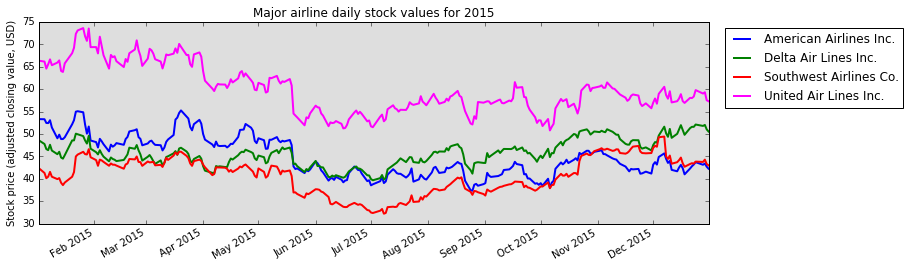

In [11]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.patch.set_facecolor('#DEDEDE')
stocks_formatted = stock_data[['Adj_Close','airline_name','Date']].pivot(
                                        index='Date',columns='airline_name',values='Adj_Close')
stocks_formatted.plot(legend=None,ax=ax,lw=2,color=colors)
ax.legend(bbox_to_anchor=(1.3,1.0))
ax.set_xlabel('')
ax.set_ylabel('Stock price (adjusted closing value, USD)')
ax.set_title("Major airline daily stock values for 2015",fontsize='large');


### Putting it all together

Now that we have our stock and flight delay data, we can combine them and start getting at our real question of interest. We'll start by doing some housekeeping to trim down to just the columns that should be useful. For the stock data, we'll just look at the adjusted daily closing prices. For the flight data, we're going to keep the departure and arrival delay information, information on whether flights were cancelled or diverted, and also the breakdown information on the cause of delays (i.e. were they they due to the weather, a National Aviation System issue, a securty incident, a late aircraft arrival, or the direct responsibility of the carrier). The last two are arguably the only cases where problems were the "fault" of the airline, though late arrivals are of course a bit complicated. It's not obvious whether a delay caused by late aircraft arrival (which most likely was caused by a late departure from the originating airport) should be attributed to the airline or to another cause, at least not a priori. We could do something clever by linking subsequent flights on the same plane in the dataset using tail number information, but that's more involved than I'm going to get into here.

In [12]:
stocks_trimmed = stock_data[['Date','Adj_Close','airline_name']].set_index('Date')
flights_trimmed = flight_data[['airline_name','DEP_DELAY_NEW','ARR_DELAY_NEW','CANCELLED','DIVERTED',
                               'CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]


The simplest thing to do is just overlay the flight delay and stock information on the same plot:

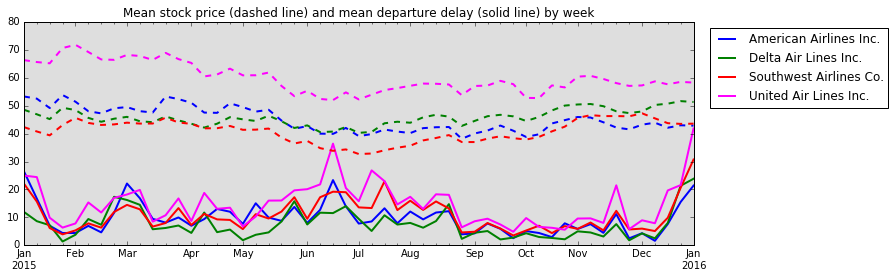

In [13]:
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.patch.set_facecolor('#DEDEDE')
mean_data = flight_data.groupby('airline_name')['DEP_DELAY'].resample('W',how='mean').unstack(level=0) 
mean_data.plot(ax=ax,color=colors,lw=2,legend=None)
stocks_formatted.resample('W',how='mean').plot(ax=ax,lw=2,legend=None,ls='--',color=colors)
ax.set_xlabel('')
ax.set_ylabel('')
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[:4],labels[:4],bbox_to_anchor=(1.3,1.0))
ax.set_title("Mean stock price (dashed line) and mean departure delay (solid line) by week");


The message here is not totally clear. While there's a hint that stock prices dropped and delays increased in the Summer months, it's far from conclusive, and certainly not causal.

To be a bit more systematic, we can generate a scatter plot of mean delays and stock prices, and check the correlation. For visualization purposes, we'll normalize the stock prices here.

American Airlines Inc.: r = 0.0690 (p=0.2754)
Delta Air Lines Inc.: r = -0.0506 (p=0.4238)
Southwest Airlines Co.: r = -0.2933 (p=0.0000)
United Air Lines Inc.: r = -0.1914 (p=0.0023)


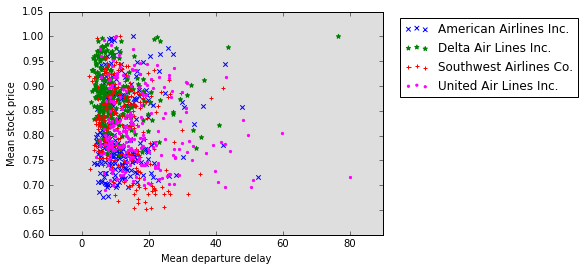

In [14]:
from scipy.stats import pearsonr
stocks_normed = stocks_trimmed.groupby('airline_name').apply(lambda df: df['Adj_Close']/df['Adj_Close'].max()).T
fig,ax = plt.subplots(1,1)
shapes = ['x','*','+','.']
year_range = pd.date_range(start='2015-01-01',end='2015-12-31',freq='D')
for airline,c,shape in zip(top_carriers,colors,shapes):
    x = flights_trimmed[flights_trimmed['airline_name']==airline]['DEP_DELAY_NEW'].resample(
            'D',how='mean').reindex(year_range)
    y = stocks_normed[airline].resample('D',how='mean').reindex(year_range)
    corr,pval = pearsonr(x[~np.isnan(y)],y.dropna())
    print "{}: r = {:.4f} (p={:.4f})".format(airline,corr,pval)
    ax.scatter(x,y,color=c,marker=shape,label=airline)
ax.patch.set_facecolor('#DEDEDE')
ax.set_xlabel('Mean departure delay')
ax.set_ylabel('Mean stock price')
ax.legend(bbox_to_anchor=(1.6,1.0));

The result is pretty noisy, and there's no systematic relationship for American Airlines or delta. For United and Southwest, however, we do see a modest negative correaltion, which suggests that greater delays *are* associated with lower stock prices.

But let's dig a bit deeper. First off, there are two general approaches we can apply to (possibly) reduce noise. One is to resample the data at larger intervals (i.e. instead of looking at per-day average delays as compared to daily stock prices, we can look at weekly or monthly averages of those same values). Second, instead of looking at the mean length of the delay, we can apply a simple binary classification of flights as either being delayed or not. The more important thing may not be the precise magnitutde of a delay, but in the aggregate, how often flights on a given airline are delayed, period. We can define two simple binary indicators here, one for short delays (of 10 to 30 minutes, where we assume that delays of less than 10 minutes don't really matter), and one for long delays (of 30 or more minutes).

In [15]:
# don't worry about the warning here...
flights_trimmed.loc[:,'small_delay'] = flights_trimmed.loc[:,'DEP_DELAY_NEW'].apply(
    lambda x: 1 if (x>=10) and (x<30) else 0)
flights_trimmed.loc[:,'big_delay'] = flights_trimmed.loc[:,'DEP_DELAY_NEW'].apply(lambda x: 1 if x>=30 else 0)

/Users/jlorince/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jlorince/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now let's look at the same scatter plot and correlation across these different ways of measuring delays and across different resampling routines. We'll also look at flight cancellations and diversions. Finally, we can consider our cause-of-delay information. This data is actually broken down such that, for each, flight we know the contribution of each type of delay do the overall delay time, so we'll consider carrier delays, as well as the combined effects of carrier delays and late aircraft arrival delays.

In the plots below, the columns indicate the resampling procedure (daily, weekly, or monthly), and each row is a different measure of delay performance. Each plot is annotated with the relevant correlation statistics.

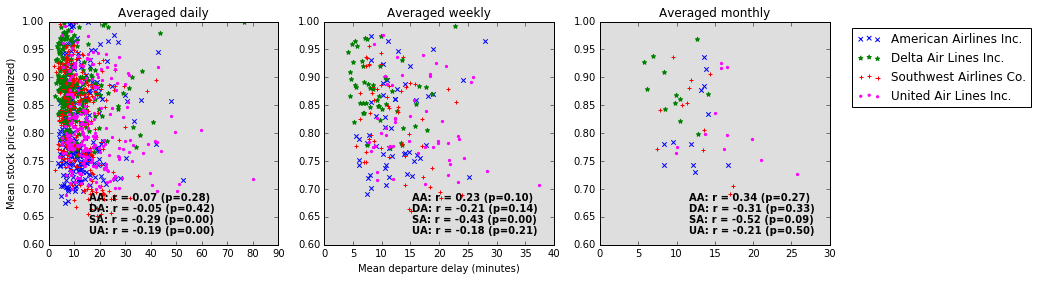

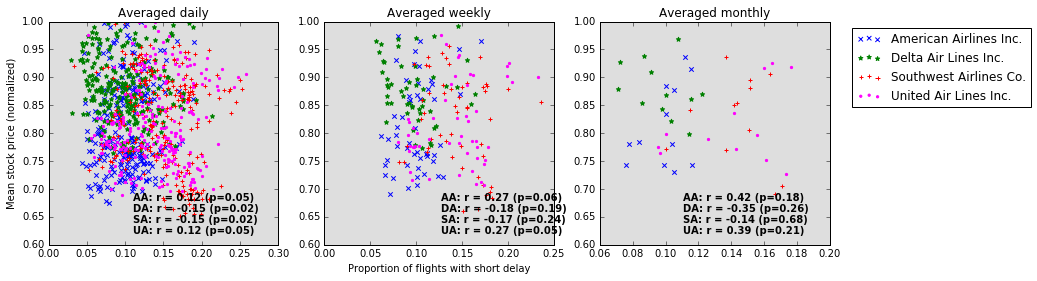

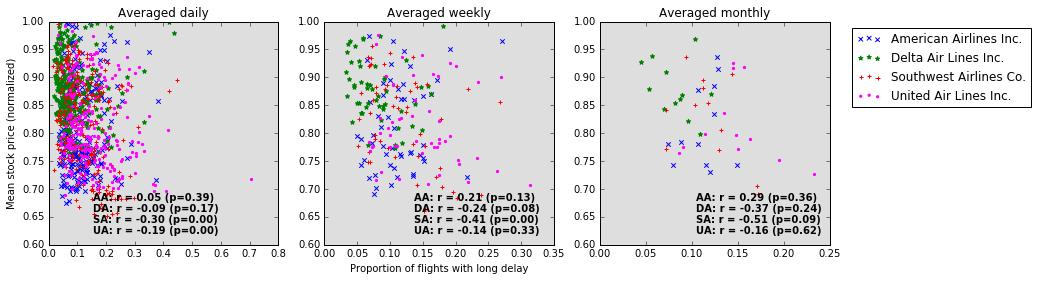

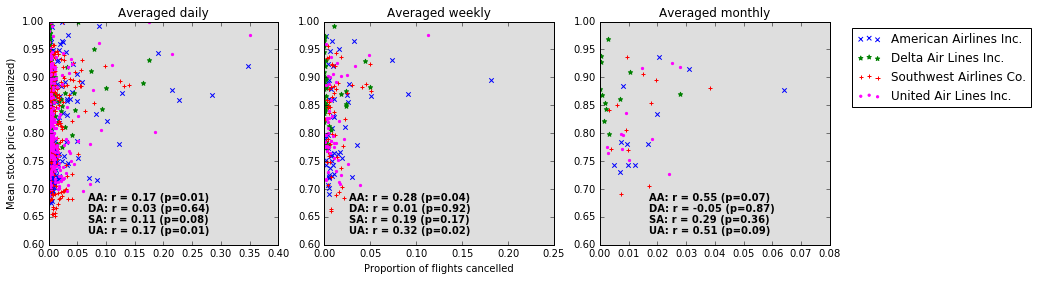

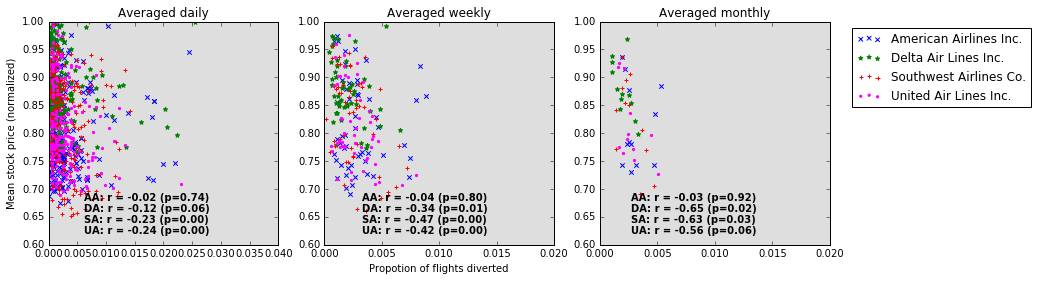

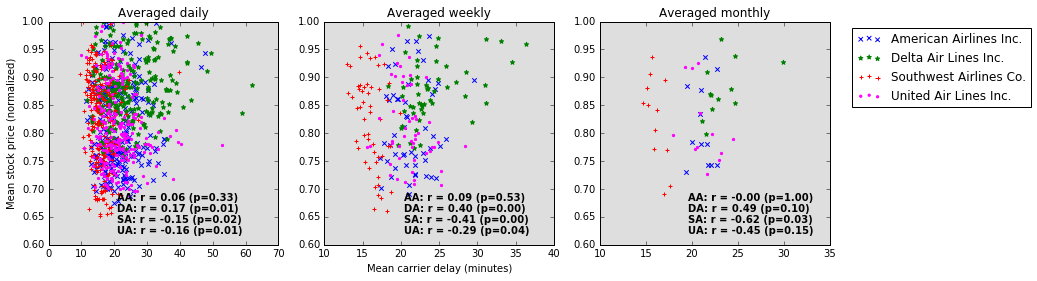

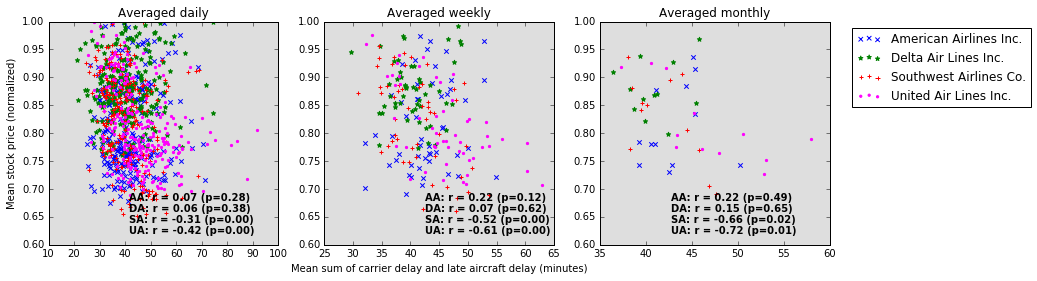

In [16]:
short_names = {full:short for full,short in zip(top_carriers,['AA','DA','SA','UA'])}
from collections import OrderedDict # just so we maintain the order we want here
measure_dict = OrderedDict([('DEP_DELAY_NEW','Mean departure delay (minutes)'),
                            ('small_delay','Proportion of flights with short delay'),
                            ('big_delay','Proportion of flights with long delay'),
                            ('CANCELLED','Proportion of flights cancelled'),
                            ('DIVERTED','Propotion of flights diverted'),
                            ('CARRIER_DELAY','Mean carrier delay (minutes)'),
                            ('carrier+late_aircraft','Mean sum of carrier delay and late aircraft delay (minutes)')])
for measure in measure_dict:
    fig,axes = plt.subplots(1,3,figsize=(14,4))
    for i,freq in enumerate(['D','W','M']):
        year_range = pd.date_range(start='2015-01-01',end='2015-12-31',freq=freq)
        offset=0
        if measure=='carrier+late_aircraft':
            f = (flights_trimmed['CARRIER_DELAY'] + \
                            flights_trimmed['LATE_AIRCRAFT_DELAY']).resample(freq,how='mean')
            anno_xcorr = f.min()+(f.max()-f.min())/2.5
        else:
            f = flights_trimmed[measure].resample(freq,how='mean')
            anno_xcorr = f.min()+(f.max()-f.min())/2.5
        for airline,c,shape in zip(top_carriers,colors,['x','*','+','.']):
            if measure == 'carrier+late_aircraft':
                flights = flights_trimmed[flights_trimmed['airline_name']==airline]
                x = (flights['CARRIER_DELAY']+flights['LATE_AIRCRAFT_DELAY']).resample(
                                                                 freq,how='mean').reindex(year_range)
            else:
                x = flights_trimmed[flights_trimmed['airline_name']==airline][measure].resample(
                                                                 freq,how='mean').reindex(year_range)
            y = stocks_normed[airline].resample(freq,how='mean').reindex(year_range)
            corr,pval = pearsonr(x[~np.isnan(y)],y.dropna())
            axes[i].annotate("{}: r = {:.2f} (p={:.2f})".format(short_names[airline],corr,pval),
                                                                 (anno_xcorr,0.68-offset),fontweight='bold')
            axes[i].scatter(x,y,color=c,marker=shape,label=airline)
            offset+=0.02
        axes[i].patch.set_facecolor('#DEDEDE')
        axes[i].set_title("Averaged {}".format({'D':'daily','W':'weekly','M':'monthly'}[freq]))
        axes[i].set_ylim(0.6,1)
        if axes[i].get_xlim()[0]<0:
            axes[i].set_xlim(left=0)
    axes[1].set_xlabel(measure_dict[measure])
    axes[0].set_ylabel('Mean stock price (normalized)')
    axes[-1].legend(bbox_to_anchor=(1.9,1.0));

We can draw a few conclusion from what we see above:
 - The resampling seems to have helped at the weekly level, but with monthly resampling we're down to only 12 data points per airline, which isn't much to go on (note the large p-values for the correlations). Monthly resampling may prove more useful with a multi-year analysis.
 - Relationships are weaker when we only consider short delays (not surprising), but when we consider the proportion of flights with long delays, we get similar results as when doing a a direct correlation between delay times and stock prices.
 - There are some big surprises, such as the *positive* correlation between stock prices and delays for Delta when considering Mean carrier delay
 
For now, let's focus on the weekly-resampled simple correlations between flight delays and stock prices (first row, middle column). For three of the four airlines we see weak to moderate correaltions, but the p-values for two of these are quite high and we can't put much stock in them. Southwest shows the most comeplling data, with a moderate negative correlation conistent with the relationship we've been testing for. American Airlines is the strangest case, and actually shows a *positive* relationship between delays and stock prices. But we could have guessed from the get-go that American, with its US Airways merger in 2015, might have been "weird" with respect to stock prices. And of course the p-values for that correlation is 0.1, so not a measure we should put great stock in.

So all in all, these results, while suggestive of a relationship, aren't too compelling (and there are some standout contradictory results). But of course we are looking at two variables amidst an ocean of factors interacting in complex ways we can't imagine to get at with this dataset. Nonetheless, let's move on to a causality analysis to see if we can make more progress.

### Applying Granger causality

Causality is a messy, philoshophical issue, but luckily *Granger* causality is a little less fraught. The basic idea is this: Given two time series `X` and `Y`, we can say that `X` Granger-causes `Y` if `X`, combined with past values of `Y`, does a better job at predicting future values of `Y` than past values of `Y` alone. We accomplish this by running statsitcal tests (t-tests or F-tests, typically) on `X` and lagged values of `Y`, where the amount of lag is a model parameter. It's not causality in the strict sense, of course, because it cannot account for exogenous factors that may influence both `X` and `Y`, but it gets us a lot closer than looking at simple correlation. 

Lots of credit to Wes McKinney's [great slides](https://conference.scipy.org/scipy2011/slides/mckinney_time_series.pdf) on this topic, which were very helpful in informing this analysis.

Let's start by just looking at American Airlines. We'll examine at the daily-sampled data (`freq = 'd'`) for now, building a new dataframe of the stock prices and mean daily flight delay.

In [17]:
airline = top_carriers[0]
freq = 'D'
year_range = pd.date_range(start='2015-01-01',end='2015-12-31',freq=freq)
measure = 'DEP_DELAY_NEW'
print airline
data = pd.DataFrame({'stock_prices':stocks_formatted[airline].resample(freq,how='mean').reindex(year_range),
                    'delays':flights_trimmed[flights_trimmed['airline_name']==airline][measure].resample(
                                                            freq,how='mean').reindex(year_range)}).dropna(0)


American Airlines Inc.


To actually run the analysis, we'll build a vector autoregression model of our data, the optimal order of which will tell us the appropriate lag to use in our Granger causality model. This order can be determined by any of several standard information criterions (AIC, BIC, etc.). Let's build the model, and consider lags of up to 30 days:

In [18]:
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(data)
best_orders = model.select_order(30)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         6.770        6.801        871.4        6.783
1         3.911       4.003*        49.96       3.948*
2        3.909*        4.062       49.83*        3.970
3         3.941        4.155        51.45        4.027
4         3.960        4.236        52.47        4.072
5         3.983        4.320        53.69        4.119
6         4.010        4.408        55.15        4.171
7         4.031        4.491        56.33        4.216
8         4.037        4.559        56.71        4.248
9         4.027        4.610        56.15        4.262
10        4.055        4.699        57.76        4.315
11        4.089        4.794        59.74        4.373
12        4.117        4.884        61.51        4.427
13        4.143        4.971        63.15        4.477
14        4.149        5.038        63.56        4.508
15        

We can see that a lag of either 1 or 2 days is best (depending on the information criterion), so we'll test both for completeness. We'll also check for causality in both directions. Our question was whether delays lead to decreases in stock prices, but the opposite effect is conceivable.

In [19]:
for lag in (1,2):
    print '\nlag = '+str(lag)
    print '-'*100+'\n'
    result = model.fit(lag)
    result.test_causality('stock_prices', 'delays')
    result.test_causality('delays', 'stock_prices')


lag = 1
----------------------------------------------------------------------------------------------------

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.682562         3.860275            0.409  (1, 496)
H_0: ['delays'] do not Granger-cause stock_prices
Conclusion: fail to reject H_0 at 5.00% significance level
Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         0.567423         3.860275            0.452  (1, 496)
H_0: ['stock_prices'] do not Granger-cause delays
Conclusion: fail to reject H_0 at 5.00% significance level

lag = 2
----------------------------------------------------------------------------------------------------

Granger causality f-test
   Test statistic   Critical Value          p-value        df
---------------------------------------------------

Clearly, no significant effects exists here. But let's check out the other airlines, as well as expanding the scope of our analysis to consider both weekly and daily data resmpling, as well as the four mesaures of delay performance we define above. We'll save a summary of all cases where we get a signficant result (using the standard `p<0.05` threshold) as we go.

In [20]:
results = []
for freq in ('D','W'):
    year_range = pd.date_range(start='2015-01-01',end='2015-12-31',freq=freq)
    for measure in measure_dict:
        for airline in top_carriers:
            if measure == 'carrier+late_aircraft':
                flights = flights_trimmed[flights_trimmed['airline_name']==airline]
                f_data = (flights['CARRIER_DELAY']+flights['LATE_AIRCRAFT_DELAY']).resample(
                                                    freq,how='mean').reindex(year_range)
            else:
                f_data = flights_trimmed[flights_trimmed['airline_name']==airline][measure].resample(
                                                    freq,how='mean').reindex(year_range)
            data = pd.DataFrame({'stock_prices':stocks_formatted[airline].resample(
                                        freq,how='mean').reindex(year_range,method='ffill'),
                                'delays':f_data}).dropna(0)
            model = VAR(data)
            if freq == 'd':
                best_orders = model.select_order(30,verbose=False)
            elif freq == 'w':
                best_orders = model.select_order(4,verbose=False)            
            for lag in set(best_orders.values()):
                result = model.fit(lag)
                granger_result = result.test_causality('stock_prices', 'delays',verbose=False)
                pv = granger_result['pvalue']
                if pv<0.05:
                    coef = result.coefs[lag-1][1][0]
                    result_list = [airline,lag,{'D':'daily','W':'weekly','M':'monthly'}[freq],
                                   measure_dict[measure],granger_result['statistic'],pv,'predicted',coef]
                    results.append(result_list)
                granger_result = result.test_causality('delays', 'stock_prices',verbose=False)
                pv = granger_result['pvalue']
                if pv<0.05:
                    coef = result.coefs[lag-1][0][1]
                    result_list = [airline,lag,{'D':'daily','W':'weekly','M':'monthly'}[freq],
                                   measure_dict[measure],granger_result['statistic'],pv,'opposite',coef]
                    results.append(result_list)

In [21]:
summary = pd.DataFrame(results)
summary.columns = ['airline','lag','resampling','measure','statistic','p-value','direction','coefficient']
summary.sort_values(['airline','direction'])
summary['coef_dir'] = summary['coefficient'].apply(lambda x: -1 if x<=0 else 1)
summary

,airline,lag,resampling,measure,statistic,p-value,direction,coefficient,coef_dir
0,Southwest Airlines Co.,1,daily,Mean departure delay (minutes),4.551578,0.033378,predicted,-0.017763,-1
1,Southwest Airlines Co.,1,daily,Mean departure delay (minutes),5.174128,0.023352,opposite,-0.192935,-1
2,Southwest Airlines Co.,2,daily,Mean departure delay (minutes),3.274127,0.038680,opposite,-0.581447,-1
3,Southwest Airlines Co.,1,daily,Proportion of flights with long delay,5.506447,0.019339,predicted,-1.888510,-1
4,Southwest Airlines Co.,1,daily,Proportion of flights with long delay,4.947751,0.026574,opposite,-0.001900,-1
5,Southwest Airlines Co.,2,daily,Proportion of flights with long delay,3.116607,0.045187,opposite,-0.004838,-1
6,American Airlines Inc.,1,daily,Proportion of flights cancelled,6.565661,0.010691,opposite,0.001401,1
7,American Airlines Inc.,2,daily,Proportion of flights cancelled,3.310691,0.037309,opposite,-0.001236,-1
8,United Air Lines Inc.,1,daily,Proportion of flights cancelled,5.068161,0.024806,opposite,0.000801,1
9,United Air Lines Inc.,2,daily,Proportion of flights cancelled,3.325757,0.036758,opposite,0.000817,1


In the table above, we can see all the granger causality tests that were significant (at the `p<0.05` threshold), and taken together, the story is an inconclusive one. Note that the `direction` column indicates whether the effect detected was in the direction we predicted (delays influencing stock prices) or the opposite (stock prices influencing delays). The `coefficient` column extracts the regression coefficient from our VAR model to test if what the caused effect was an increase or a decrease. That is, given that delays have a predictive relationship with stock prices, do they predict increases or decreases in stock prices (or vice versa)? `coef_dir` simply binarizes this value.

Things are pretty messy here, so let's generate an even higher level summary:

In [22]:
summary.groupby(['airline','resampling','direction','coef_dir']).count()['lag']

airline                 resampling  direction  coef_dir
American Airlines Inc.  daily       opposite   -1          1
                                                1          1
Delta Air Lines Inc.    daily       opposite    1          3
                        weekly      predicted  -1          2
Southwest Airlines Co.  daily       opposite   -1          9
                                    predicted  -1          5
                        weekly      opposite   -1          3
                                    predicted  -1          1
United Air Lines Inc.   daily       opposite   -1          2
                                                1          4
                        weekly      opposite   -1          3
                                                1          1
Name: lag, dtype: int64

Now, we can see, for each combination of airline and resampling level, the distribution of effects (both in terms of the direction of causality, and whether the caused effect was an increase) across the different Granger tests. The take home message here? Things are a lot more complicated that we can conclusively examine with the methods we have applied.

Consider Southwest, for instance. Here we see, across various tests, effects in *both* the predicted (delays => stock prices) and opposite (stock prices => delays directions). In all cases the coefficient was negative, meaning that increases in one variable lead to decreases in the other (which matches our intuitions), but the fact that we see predictive causality in both directions indicates a more complicated situation than is captured by these variables alone.

However, there are multiple cases where the coefficient is actually *positive*, which would indicate that greater delays are associated with higher stock prices (though we saw hints of this in our earlier correlational analysis). This remains the case even if we use a more conservative p-value threshold:

In [23]:
summary[summary['p-value']<0.01]

,airline,lag,resampling,measure,statistic,p-value,direction,coefficient,coef_dir
10,Southwest Airlines Co.,1,daily,Propotion of flights diverted,10.254179,0.001451,opposite,-0.000140,-1
12,Southwest Airlines Co.,2,daily,Propotion of flights diverted,4.680940,0.009689,opposite,-0.000302,-1
13,United Air Lines Inc.,1,daily,Propotion of flights diverted,14.492842,0.000158,opposite,-0.000129,-1
14,United Air Lines Inc.,2,daily,Propotion of flights diverted,7.255964,0.000784,opposite,0.000035,1
20,Southwest Airlines Co.,1,daily,Mean sum of carrier delay and late aircraft de...,12.996299,0.000344,opposite,-0.413576,-1
22,Southwest Airlines Co.,2,daily,Mean sum of carrier delay and late aircraft de...,6.000867,0.002662,opposite,-0.923201,-1
23,United Air Lines Inc.,1,daily,Mean sum of carrier delay and late aircraft de...,23.127261,0.000002,opposite,-0.596499,-1
24,United Air Lines Inc.,2,daily,Mean sum of carrier delay and late aircraft de...,9.719218,0.000073,opposite,0.186712,1
30,United Air Lines Inc.,1,weekly,Mean carrier delay (minutes),8.552228,0.004306,opposite,-0.179355,-1
33,United Air Lines Inc.,1,weekly,Mean sum of carrier delay and late aircraft de...,17.807734,0.000055,opposite,-0.738264,-1


So how do we interpret this? We can certainly say that there are detectable relationships between airline delays stock prices, but the heterogeneity of results across our correlational and Granger causality tests do not paint a conclusive picture of the form of this relationship.

### Conclusions and wrap-up

It would seem our wishful thinking that airlines with worse delays would be penalized by the stock market isn't borne out, at least not in any conclusive way with the data and analyses applied here. Everything we have seen suggests a more complicated relationship than we could effectively examine here, which is little surprise. Both stock prices and flight delays are influenced by countless exogenous factors, including public perception of airlines, fuel prices, changes in people's aggregate traveling patterns, corporate reorganization, and many more. It may simply be the case that a systematic effect, if it exists, is not detectable in the relatively subsample of flight data we used here. 

So what could we do in the future to get a more conclusive answer?

 - First off, we could use more data. While the 3M+ flights (after filtering to the top airlines) used here may seem like a lot, once we start doing daily or weekly resampling of this data, teh effective number of datapoints goes way down. There are lots of complications to handle if we want to look at multiple years of data, not just in terms of pure data size, but also in terms of data cleaning. Airline mergers in particular complicate matters, especially since most publicly available stock market data sources do not make data available for airlines that aren't around any more (US Airways, Continental, etc.). Even when one airline acquires another, they may change their stock symbol and old stock data for the extant airline becomes unavailable (this happened with the US Airways / American merger, for instance).
 - We could of course try to control for more exogenous effects on stock prices and delays (see a few examples above), but this is a tricky proposition. Especially when considering multiple years of data, we have to think of such factors evolve over time. 
 - Finally, we could apply different analytic methods. Granger causality is a useful too, but perhaps not the ideal one here. Researchers at Google recently introduced a [new method](http://research.google.com/pubs/pub41854.html) for inferring causal impact in time series that might be useful.